In [19]:
import numpy as np
import pytest

import pandas
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
now = datetime.datetime.now()
now = str(now)[2:10].replace('-','');
import bioframe


import h5py 
import bbi

bioframe.__version__

'0.4.1'

In [20]:
binding_frequencies = pd.read_table('./sonmezer2021_SMF.CTCF.data_03-27-22/binding.frequencies.tsv',sep='\t')

binding_sites_df = pd.read_csv('sonmezer2021_SMF.CTCF.data_03-27-22/binding.sites.filtered.mm10.tsv',sep='\t')


In [3]:
scd_stats = ['SCD','SSD','INS-16','INS-32','INS-64','INS-128','INS-256']

In [10]:
scd_out = h5py.File('./scd_ins_sonmezer/scd.h5','r')
s = []
for key in scd_out.keys():
    if key.replace('ref_','').replace('alt_','') in scd_stats:
        s.append(pd.Series(scd_out[key][()].mean(axis=1) , name=key) ) 
    else:
        s.append(pd.Series(scd_out[key][()],name=key)  )
seq_coords_df = pd.concat(s,axis=1)

for key in ['rownames','strand','chrom','TF']:
    seq_coords_df[key] = seq_coords_df[key].str.decode('utf8').copy()

scd_out.close()

In [17]:
for key in ['INS-16','INS-32','INS-64','INS-128','INS-256']:
    seq_coords_df[key] = (seq_coords_df['ref_'+key ]-seq_coords_df['alt_'+key]).values
seq_coords_df.drop_duplicates('rownames',inplace=True)
seq_coords_df.shape

(9991, 29)

In [15]:
with h5py.File('scd_ins_sonmezer/scd.h5','r') as scd_out:
    print(
        scd_out.keys())
    print(scd_out['SCD'].shape)
    s = scd_out['SCD'][()]


<KeysViewHDF5 ['SCD', 'SSD', 'TF', 'alt_INS-128', 'alt_INS-16', 'alt_INS-256', 'alt_INS-32', 'alt_INS-64', 'chrom', 'end', 'isBound', 'name', 'phyloP', 'ref_INS-128', 'ref_INS-16', 'ref_INS-256', 'ref_INS-32', 'ref_INS-64', 'rmsk', 'rownames', 'score', 'start', 'strand', 'width']>
(10010, 6)


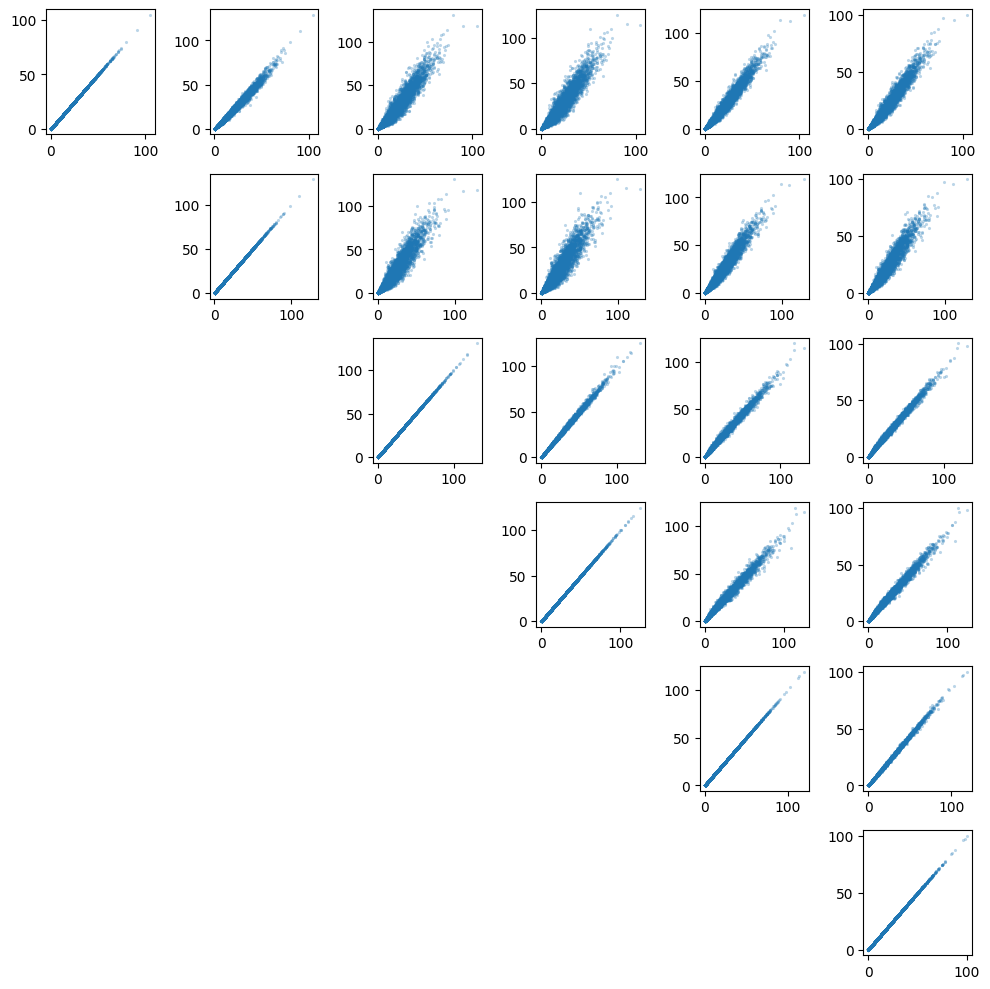

In [16]:
plt.figure(figsize=(10,10))
for i in range(6):
    for j in range(6):
        if j < i: continue
        plt.subplot(6,6,6*i+j+1)
        plt.scatter(s[:,i],s[:,j],5,alpha=0.3,lw=0)
plt.tight_layout()
#plt.scatter(s[:,0],s[:,1],5,alpha=0.3,lw=0)

In [21]:
binding_sites_df[['chrom','start','end','chipseq.score']][0:3]

,chrom,start,end,chipseq.score
0,chr1,9541413,9541431,401.092987
1,chr1,9541469,9541487,401.092987
2,chr1,9545334,9545352,255.647003


In [22]:
seq_coords_df = seq_coords_df.merge(binding_sites_df[['chrom','start','end','chipseq.score']], on=['chrom','start','end'], how='left')

In [23]:
### merging binding frequency info with sequence positions & scores
seq_coords_df.set_index('rownames', inplace=True)
c = 0
for item in binding_frequencies.values:
    c+=1
    if np.mod(c,5000)==0: print(c)
    #print(item)
    if item[0] in seq_coords_df.index:
        seq_coords_df.loc[item[0],item[1]] = item[-1]
print('done', seq_coords_df.shape)

5000
10000
15000
20000
25000
done (9991, 32)


In [24]:
seq_coords_df.fillna(0, inplace=True)
seq_coords_df.reset_index(inplace=True)

In [25]:
seq_coords_df_expaned = bioframe.expand(bioframe.expand(seq_coords_df, scale=0),pad=100)
seq_coords_df_expaned['end']-seq_coords_df_expaned['start'] ### size 200 like in sonmezer
chip_dict = {
'justice_2020_CTCF':'/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw',
'justice_2020_Rad21':'/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_Rad21-ChIPseq.bw',
'hansen_2019_CTCF':'/project/fudenber_735/GEO/hansen_2019_GSE123636/mm10/GSM3508478_C59_CTCF.bw',
}

for chip in chip_dict:
    if chip in seq_coords_df.keys(): print('already calculated'); continue
    print('calculating ',chip)
    with bbi.open( chip_dict[chip] ) as BBIFile:
        chip_values = BBIFile.stackup(
                        seq_coords_df_expaned['chrom'], 
                        seq_coords_df_expaned['start'], 
                        seq_coords_df_expaned['end'], 
                        bins=1, summary='sum')
    seq_coords_df[chip] = chip_values
print('done')

calculating  justice_2020_CTCF
calculating  justice_2020_Rad21
calculating  hansen_2019_CTCF
done


In [28]:
# savefig = False
# plt.rcParams['font.size']=12
# i = 0
# for key in ['justice_2020_CTCF',
#             'justice_2020_Rad21',
#             'phyloP', 'score', 
#             'Bound','Nucleosome.occupied', 'Accessible', ]:
#     plt.figure(figsize=(4,4))

#     i+=1
#     #plt.figure(figsize=(4,3))
#     #plt.subplot(2,3,i)
#     plt.scatter( seq_coords_df[key], seq_coords_df['SCD'], 5, alpha=0.1 )
#     plt.semilogy()
#     plt.xlabel(key)
#     plt.ylabel('avg SCD')
#     s = np.round(spearmanr( seq_coords_df[key], seq_coords_df['SCD'], )[0] ,2)
#     p = np.round(pearsonr( seq_coords_df[key], seq_coords_df['SCD'], )[0] ,2)
    
#     plt.title(f'spearmanR: {s} \n pearsonR: {p}')#,str(s)
#     if savefig: plt.savefig('sonmezer-scatter-'+key+'.png')
# #plt.tight_layout()

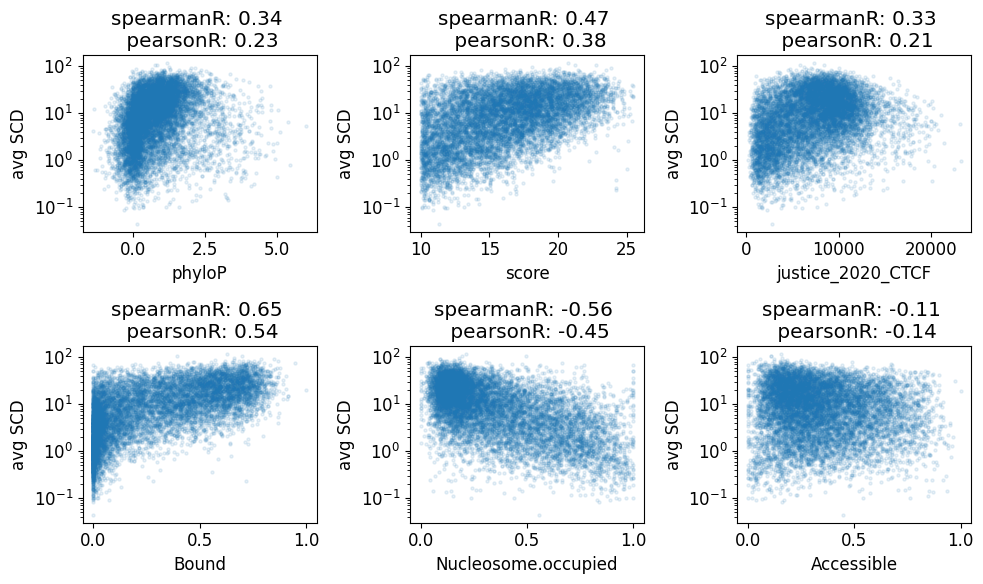

In [29]:
plt.rcParams['font.size']=12
i = 0
plt.figure(figsize=(10,6))
for key in ['phyloP', 'score', 'justice_2020_CTCF', 'Bound','Nucleosome.occupied', 'Accessible', ]:
    i+=1
    #plt.figure(figsize=(4,3))
    plt.subplot(2,3,i)
    plt.scatter( seq_coords_df[key], seq_coords_df['SCD'], 5, alpha=0.1 )
    plt.semilogy()
    plt.xlabel(key)
    plt.ylabel('avg SCD')
    s = np.round(spearmanr( seq_coords_df[key], seq_coords_df['SCD'], )[0] ,2)
    p = np.round(pearsonr( seq_coords_df[key], seq_coords_df['SCD'], )[0] ,2)
    
    plt.title(f'spearmanR: {s} \n pearsonR: {p}')#,str(s)
plt.tight_layout()

In [30]:
sonmezer_stats = [ 'Bound','Nucleosome.occupied', 'Accessible', 'phyloP', 'score', 'chipseq.score'] 
keys = ['SCD'] + sonmezer_stats + list(chip_dict.keys())
keys = scd_stats + sonmezer_stats + list(chip_dict.keys())


In [31]:
seq_coords_df_flip = seq_coords_df.copy()
for key in ['SSD', 'INS-16', 'INS-32', 'INS-64', 'INS-128', 'INS-256']:
    seq_coords_df_flip[key] = seq_coords_df_flip[key].values * -1

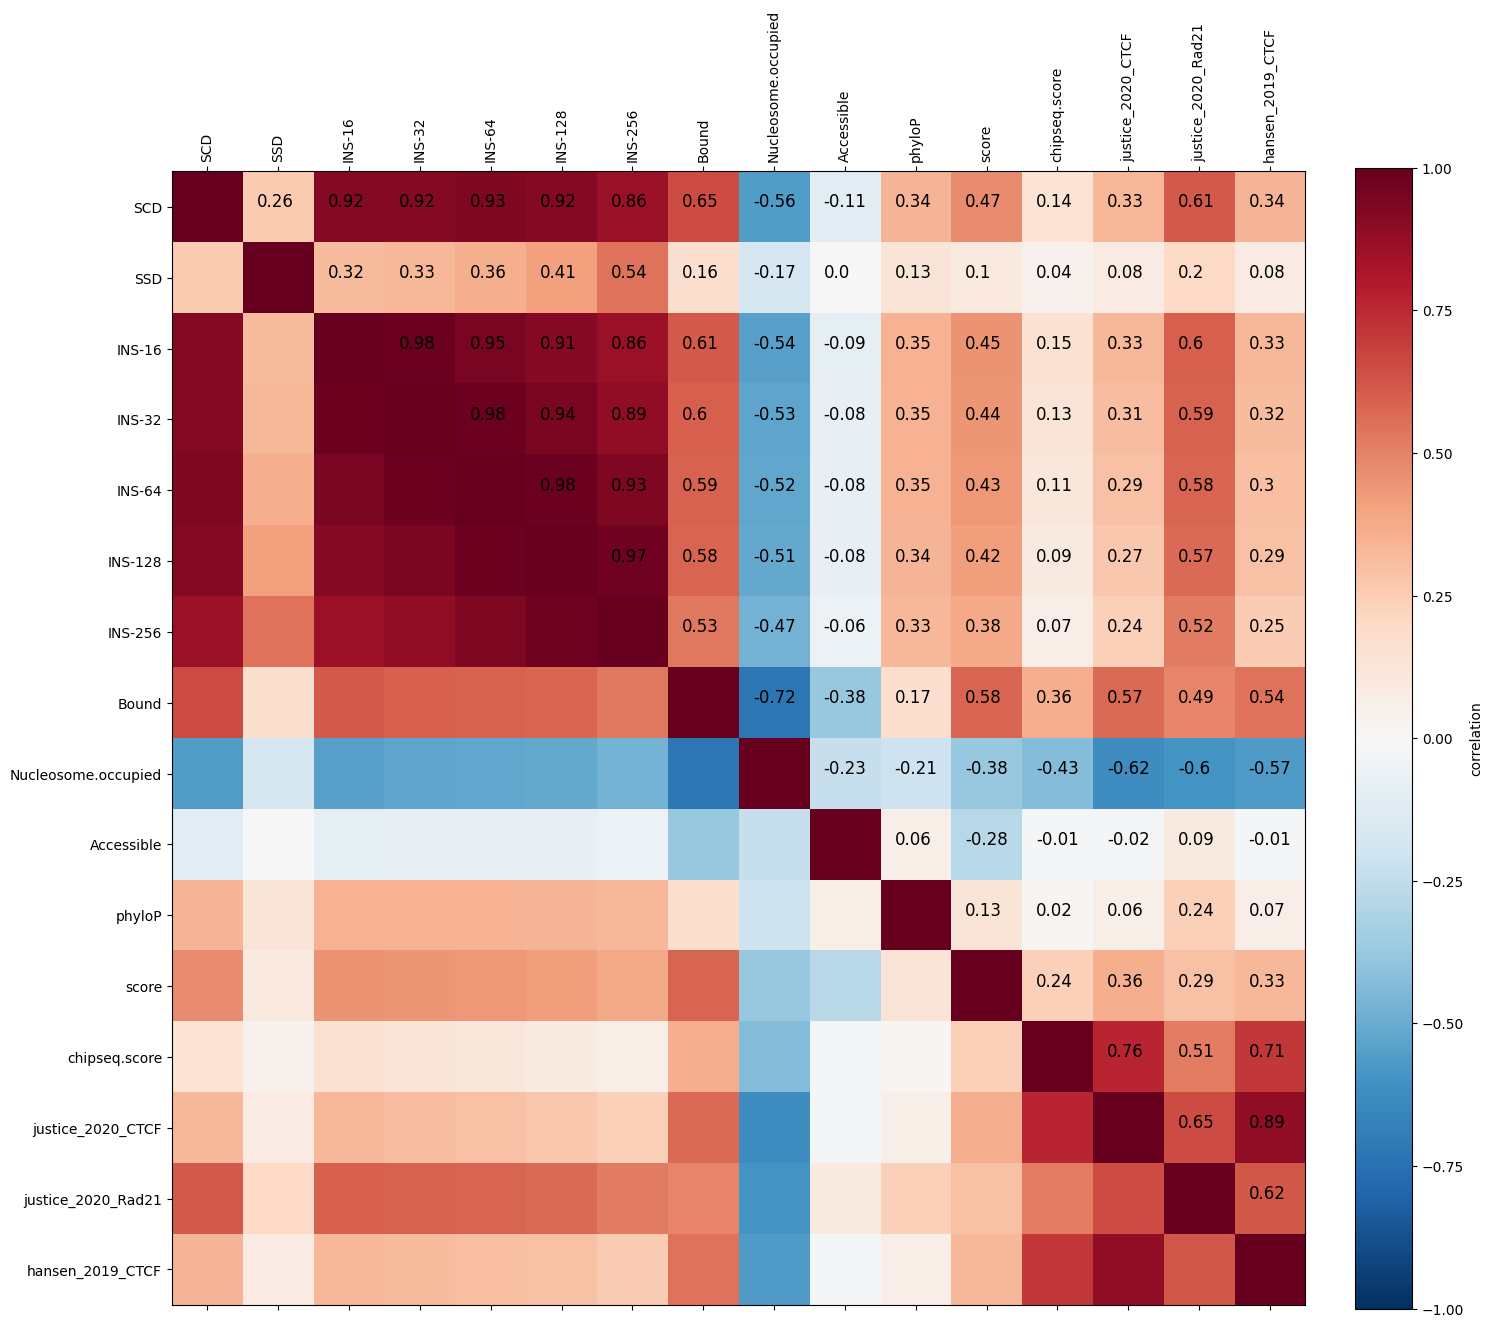

In [32]:
figwidth = 16
plt.figure(figsize=(figwidth,figwidth))#14,14))
plt.rcParams['font.size']=10

#corr_mat = np.round(spearmanr(seq_coords_df[keys].values)[0],2)
corr_mat = np.round(spearmanr(seq_coords_df_flip[keys].values)[0],2)

plt.matshow(
    corr_mat,
    fignum=False,
    cmap='RdBu_r',
    vmin=-1,vmax=1

); 
for i in range(len(keys)):
    for j in range(len(keys)):
        if i <=j:continue
        plt.text( i - 0.3 ,j,  str(corr_mat[i,j]),
                   color='k',fontsize=12 )
plt.xticks(np.arange(len(keys)), keys, rotation=90)
plt.yticks(np.arange(len(keys)), keys)

plt.colorbar(label='correlation', fraction=0.046, pad=0.04)

In [33]:
seq_coords_df['log10_SCD'] = np.log10(seq_coords_df['SCD'].values)

In [34]:
keys = ['log10_SCD','SCD', 'Bound','Nucleosome.occupied', 'Accessible','phyloP', 'score', ] + list(chip_dict.keys())

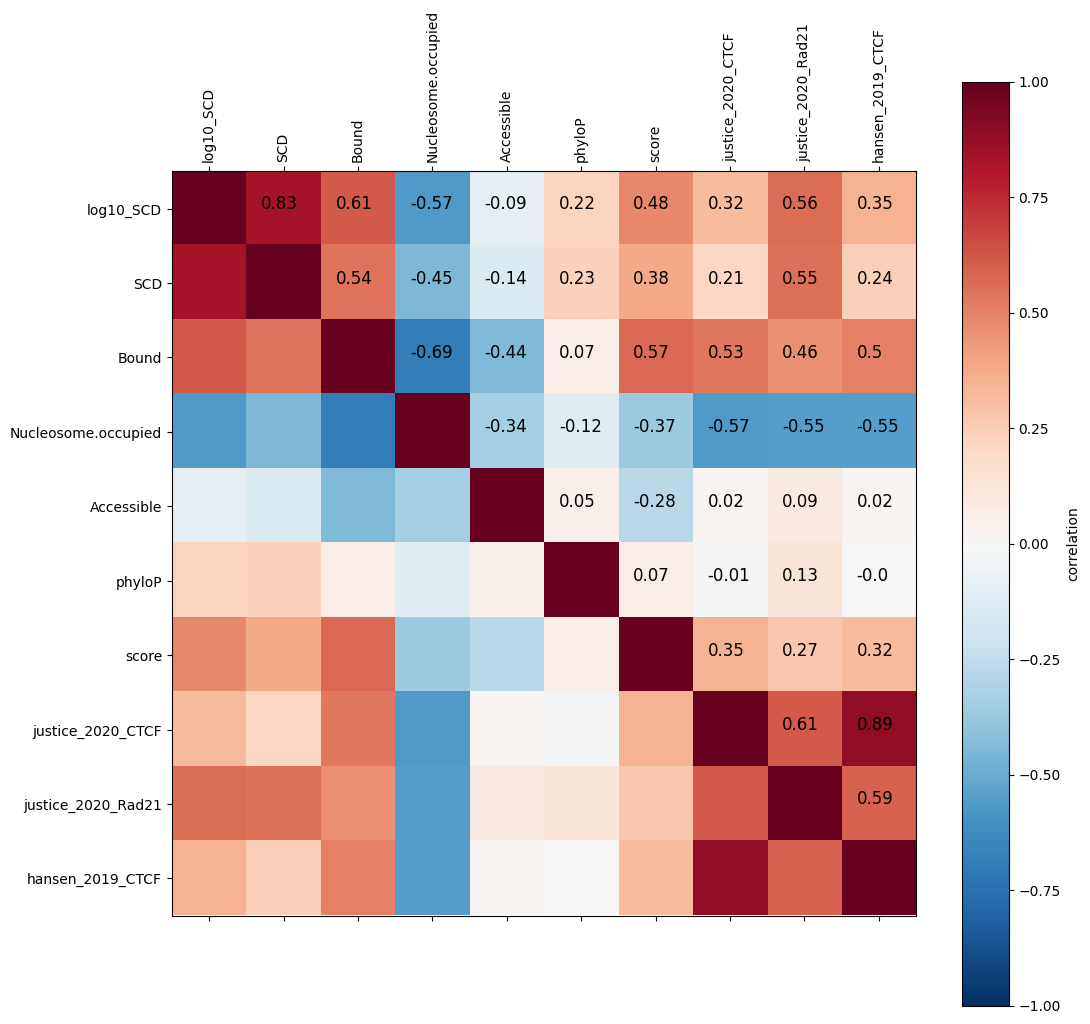

In [35]:

plt.figure(figsize=(12,12))
plt.rcParams['font.size']=10


corr_mat = np.round(seq_coords_df[keys].corr(method='pearson').values,2)

plt.matshow(
    corr_mat,
    fignum=False,
    cmap='RdBu_r',
    vmin=-1,vmax=1

); 
for i in range(len(keys)):
    for j in range(len(keys)):
        if i <=j:continue
        plt.text( i - 0.3 ,j,  str(corr_mat[i,j]),
                   color='k',fontsize=12 )
plt.xticks(np.arange(len(keys)), keys, rotation=90)
plt.yticks(np.arange(len(keys)), keys)

plt.colorbar(label='correlation')

In [38]:
import pingouin as pg

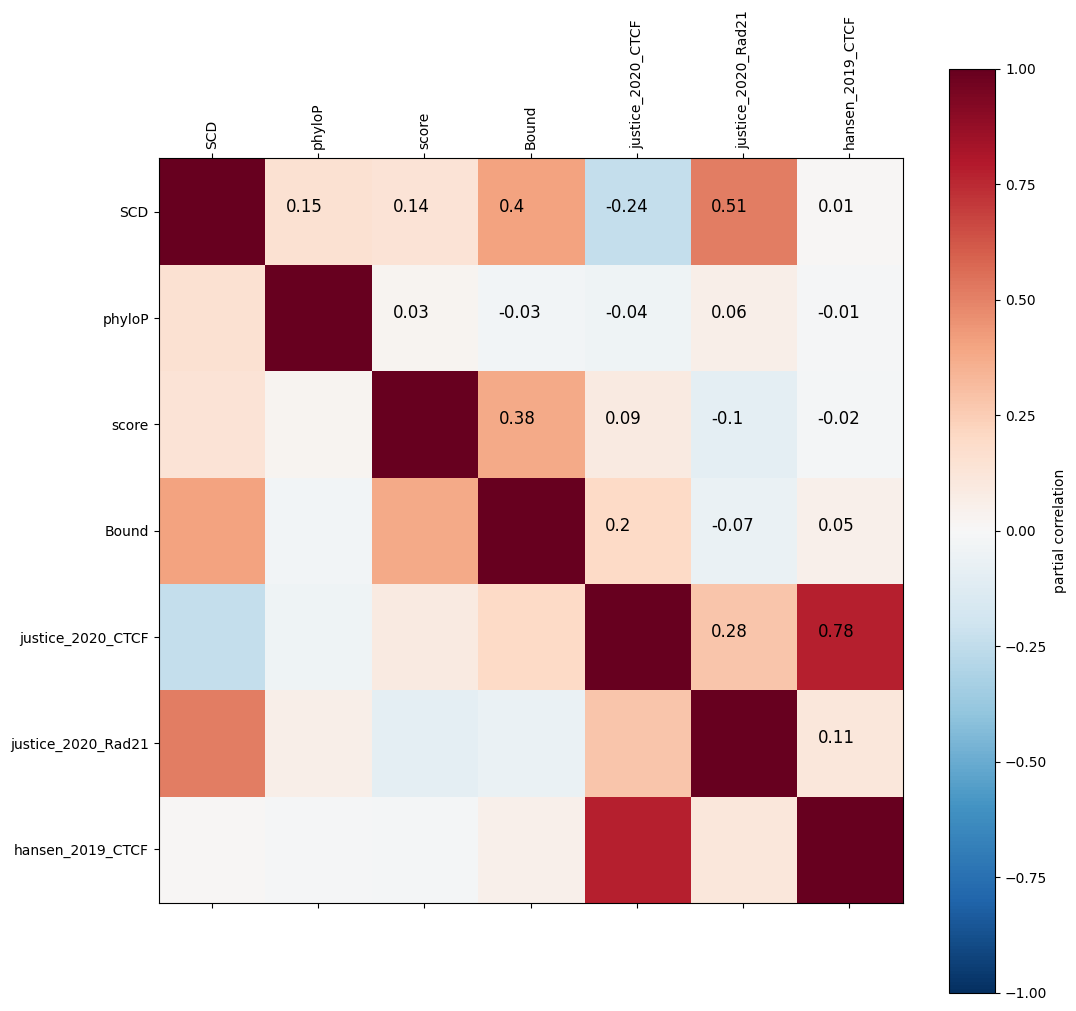

In [39]:
keys = [ 'SCD', 'phyloP', 'score', 'Bound'] + list(chip_dict.keys())
plt.figure(figsize=(12,12))
plt.rcParams['font.size']=10


corr_mat = seq_coords_df[keys].pcorr().round(2).values
                    
plt.matshow(
    corr_mat,
    fignum=False,
    cmap='RdBu_r',
    vmin=-1,vmax=1

); 
for i in range(len(keys)):
    for j in range(len(keys)):
        if i <=j:continue
        plt.text( i - 0.3 ,j,  str(corr_mat[i,j]),
                   color='k',fontsize=12 )
plt.xticks(np.arange(len(keys)), keys, rotation=90)
plt.yticks(np.arange(len(keys)), keys)

plt.colorbar(label='partial correlation')